In [8]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import gls
import math


In [2]:
X_train = pd.read_csv('../data/curated/X_train').iloc[:,2:]
y_train = pd.read_csv('../data/curated/y_train').iloc[:,1:]
X_val = pd.read_csv('../data/curated/X_val').iloc[:,2:]
y_val = pd.read_csv('../data/curated/y_val').iloc[:,1:]
X_test = pd.read_csv('../data/curated/X_test').iloc[:,2:]
y_test = pd.read_csv('../data/curated/y_test').iloc[:,1:]

In [3]:
train = pd.merge(X_train, y_train, left_index=True, right_index=True)
val = pd.merge(X_val, y_val, left_index=True, right_index=True)
test = pd.merge(X_test, y_test, left_index=True, right_index=True)

In [4]:
train = train[train['income_rate'] > 0.00]
train['inv_ir'] = 1/train['income_rate']

In [10]:
# use features after feature selection with F-test
cols = ['income_rate','total_adjusted_amount','trip_distance','fare_amount','tip_amount','precipcover','humidity','cloudcover',
'visibility']

In [11]:
# remove some large numbers to see a more clear pattern
train = train[train['income_rate']<10]
train.count()

total_adjusted_amount    31523
trip_distance            31523
fare_amount              31523
tip_amount               31523
tempmin                  31523
tempmax                  31523
temp                     31523
precip                   31523
precipcover              31523
windgust                 31523
windspeed                31523
dew                      31523
humidity                 31523
snow                     31523
snowdepth                31523
cloudcover               31523
visibility               31523
income_rate              31523
inv_ir                   31523
dtype: int64

In [ ]:
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(train[cols], plot_kws=dict(s=1, edgecolor="b", linewidth=1),)

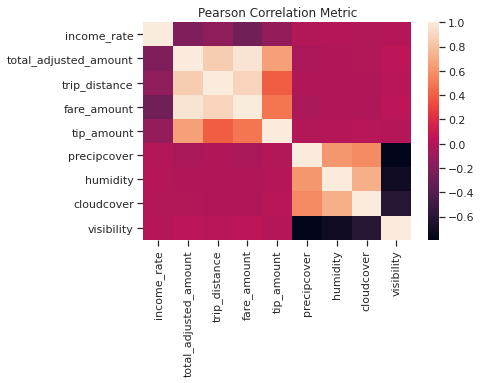

In [117]:
# Pearson correlation coefficient
sns.heatmap(train[cols].corr())
plt.title('Pearson Correlation Metric')
plt.show()

In [118]:
# since heteroskedasticity 
fit1 = gls(
    formula="income_rate ~ total_adjusted_amount+trip_distance+fare_amount+tip_amount+precipcover+humidity+cloudcover+visibility",
    data=train
).fit()

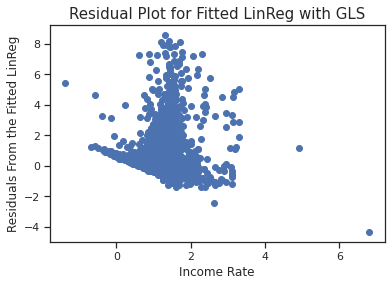

In [128]:
# checking heteroskedasticity
train_pred = fit1.fittedvalues.copy()
train_true = train['income_rate'].values.copy()
residual = train_true - train_pred
fig, ax = plt.subplots()
ax.scatter(train_pred, residual)
plt.title('Residual Plot for Fitted LinReg with GLS',fontsize=15)
plt.xlabel('Income Rate')
plt.ylabel('Residuals From the Fitted LinReg')
plt.show()
fig.savefig('../plots/5.Residual Plot for Fitted LinReg.png')

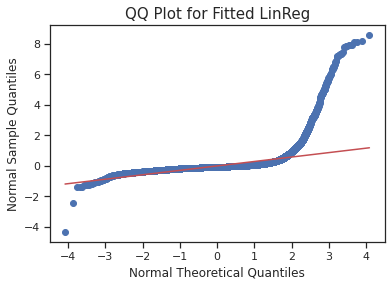

In [126]:
# checking normality distribution 
fig, ax = plt.subplots()
sp.stats.probplot(residual, plot=ax, fit=True)
plt.title('QQ Plot for Fitted LinReg',fontsize=15)
plt.xlabel('Normal Theoretical Quantiles')
plt.ylabel('Normal Sample Quantiles')
plt.show()
fig.savefig('../plots/6.QQ Plot for Fitted LinReg.png')

In [125]:
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            GLS Regression Results                            
==============================================================================
Dep. Variable:            income_rate   R-squared:                       0.182
Model:                            GLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     874.3
Date:                Wed, 31 Aug 2022   Prob (F-statistic):               0.00
Time:                        17:52:50   Log-Likelihood:                -20885.
No. Observations:               31523   AIC:                         4.179e+04
Df Residuals:                   31514   BIC:                         4.186e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 1.1220      0.003    417.933      0.000       1.117       1.127
total_adjusted_amount     0.7027      0.016     45.075      0.000       0.672       0.733
trip_distance             0.2620      0.006     43.314      0.000       0.250       0.274
fare_amount              -0.9337      0.013    -69.797      0.000      -0.960      -0.907
tip_amount               -0.1330      0.005    -28.263      0.000      -0.142      -0.124
precipcover               0.0005      0.004      0.119      0.905      -0.008       0.009
humidity                  0.0147      0.004      3.291      0.001       0.006       0.023
cloudcover               -0.0030      0.004     -0.748      0.454      -0.011       0.005
visibility                0.0204      0.005      4.159      0.000       0.011       0.030
==============================================================================
Omnibus:                    44767.414   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         13988909.912
Skew:                           8.527   Prob(JB):                         0.00
Kurtosis:                     104.782   Cond. No.                         13.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
plt.scatter(np.log(train['total_adjusted_amount']), train['income_rate'])
train['log_taa'] = np.log(train['total_adjusted_amount'])

In [ ]:
plt.scatter(np.log(train['trip_distance']), train['income_rate'])
train['log_td'] = np.log(train['trip_distance'])

In [ ]:
plt.scatter(np.log(train['tip_amount']), train['income_rate'])
train['log_ta'] = np.log(train['tip_amount'])

In [ ]:
plt.scatter(np.log(train['fare_amount']), train['income_rate'])
train['log_fa'] = np.log(train['fare_amount'])

In [ ]:
fit2 = gls(
    formula="income_rate ~ log_taa+log_td+log_fa+log_ta+precipcover+humidity+cloudcover+visibility",
    data=train
).fit()

In [ ]:
fit2.summary()

In [ ]:
# decide to use fit1 since it has a higher r_sq
cols1 = ['total_adjusted_amount','trip_distance','fare_amount','tip_amount','precipcover','humidity','cloudcover',
'visibility']
train_predictions = fit1.predict(train[cols1])
val_predictions = fit1.predict(val[cols1])
test_predictions = fit1.predict(test[cols1])

In [19]:
# calculate r square for validation set
r2_train_calc = pd.DataFrame({'obs': list(train['income_rate']), 'pred': train_predictions})

mean_training = np.mean(r2_train_calc['obs'])
r2_train_calc['Null_SS'] = (r2_train_calc['obs'] - mean_training)**2
r2_train_calc['model_SS'] = (r2_train_calc['obs'] - r2_train_calc['pred'])**2

SSR = sum(r2_train_calc['model_SS'])/len(r2_train_calc)
SST = sum(r2_train_calc['Null_SS'])/len(r2_train_calc)

R2_train = 1-SSR/SST
R2_train


print("R_squared for training set: {:.3f}".format(R2_train))
# corr_matrix_train = np.corrcoef(train['income_rate'], train_predictions)
# corr_train = corr_matrix_train[0,1]
# R_sq_train = corr_train**2
# MSE_train = np.square(np.subtract(train['income_rate'],train_predictions)).mean()

NameError: name 'train_predictions' is not defined

In [ ]:
r2_val_calc = pd.DataFrame({'obs': list(val['income_rate']), 'pred': val_predictions})

mean_validating = np.mean(r2_val_calc['obs'])
r2_val_calc['Null_SS'] = (r2_val_calc['obs'] - mean_validating)**2
r2_val_calc['model_SS'] = (r2_val_calc['obs'] - r2_val_calc['pred'])**2

SSR_val = sum(r2_val_calc['model_SS'])/len(r2_val_calc)
SST_val = sum(r2_val_calc['Null_SS'])/len(r2_val_calc)

R2_val = 1-SSR_val/SST_val
R2_val
print("R_squared for validation set: {:.3f}".format(R2_val))

In [20]:
r2_test_calc = pd.DataFrame({'obs': list(test['income_rate']), 'pred': test_predictions})

mean_testing = np.mean(r2_test_calc['obs'])
r2_test_calc['Null_SS'] = (r2_test_calc['obs'] - mean_testing)**2
r2_test_calc['model_SS'] = (r2_test_calc['obs'] - r2_test_calc['pred'])**2

SSR_test = sum(r2_test_calc['model_SS'])/len(r2_test_calc)
SST_test = sum(r2_test_calc['Null_SS'])/len(r2_test_calc)

R2_test = 1-SSR_test/SST_test
R2_test
print("R_squared for testing set: {:.3f}".format(R2_test))

NameError: name 'test_predictions' is not defined

In [ ]:
# RMSE for training set
MSE_train = np.square(np.subtract(train['income_rate'],train_predictions)).mean()
print("RMSE for training set: {:.3f}".format(math.sqrt(MSE_train)))
MSE_val = np.square(np.subtract(val['income_rate'],val_predictions)).mean()
print("RMSE for validation set: {:.3f}".format(math.sqrt(MSE_val)))
MSE_test = np.square(np.subtract(test['income_rate'],test_predictions)).mean()
print("RMSE for testing set: {:.3f}".format(math.sqrt(MSE_test)))

In [ ]:
test_predictions.to_csv('../data/curated/LR_test_prediction.csv')